In [1]:
import glob
from pandas import read_csv, concat, cut, crosstab
from numpy import round, clip, trace, tril, infty

# LISTAGEM DADOS

In [2]:
cursos = glob.glob(f'C:/Users/jullya leticia/Downloads/inep/censo_superior/**/MICRODADOS_CADASTRO_CURSOS_*.CSV')
ies = glob.glob(f'C:/Users/jullya leticia/Downloads/inep/censo_superior/**/MICRODADOS_CADASTRO_IES_*.CSV')

# SELEÇÃO COLUNAS DE INTERESSE

In [3]:
colunas_ies = ['NU_ANO_CENSO', 'CO_IES', 'NO_IES', 'SG_IES', 'NO_REGIAO_IES','SG_UF_IES', 'TP_CATEGORIA_ADMINISTRATIVA']
colunas_cursos =['NU_ANO_CENSO','CO_IES','SG_UF','QT_ING','QT_CONC','TP_ORGANIZACAO_ACADEMICA','TP_CATEGORIA_ADMINISTRATIVA',
                 'QT_ING_PROCESCPUBLICA','QT_CONC_PROCESCPUBLICA','QT_ING_PROCESCPRIVADA','QT_CONC_PROCESCPRIVADA',
                 'CO_CINE_AREA_GERAL','NO_CINE_AREA_GERAL']

# LEITURA DE DADOS

In [4]:
# Transformações iniciais nos dados de cursos
pipeline = lambda x: (
read_csv(x,encoding='ISO-8859-1',sep=';', usecols=colunas_cursos,low_memory=False)
.rename(columns = {'NU_ANO_CENSO':'ANO'})
.query('TP_ORGANIZACAO_ACADEMICA==1 & TP_CATEGORIA_ADMINISTRATIVA==1 & CO_CINE_AREA_GERAL == 5 & ANO >=2011')
.groupby(['ANO', 'CO_IES','CO_CINE_AREA_GERAL','NO_CINE_AREA_GERAL'])
.agg(QT_ING = ('QT_ING', 'sum'), QT_CONC =('QT_CONC', 'sum'),
     QT_INGpb = ('QT_ING_PROCESCPUBLICA', 'sum'), QT_CONCpb =('QT_CONC_PROCESCPUBLICA', 'sum'),
     QT_INGpv = ('QT_ING_PROCESCPRIVADA', 'sum'), QT_CONCpv =('QT_CONC_PROCESCPRIVADA', 'sum'))
.reset_index()
)
df_cursos = concat((pipeline(f) for f in cursos))

In [5]:
# Transformações iniciais nos dados de IES
pipeline = lambda x: (
read_csv(x,encoding='ISO-8859-1',sep=';',usecols=colunas_ies,low_memory=False)
.rename(columns = {'NU_ANO_CENSO':'ANO_MIN'})
.query('TP_CATEGORIA_ADMINISTRATIVA==1')
)
df_ies = concat((pipeline(f) for f in ies)).drop_duplicates(subset=['CO_IES'])
df_ies

ANO_MIN NO_REGIAO_IES SG_UF_IES  TP_CATEGORIA_ADMINISTRATIVA  CO_IES  \
0        2009  Centro-Oeste        MT                            1       1   
1        2009  Centro-Oeste        DF                            1       2   
2        2009      Nordeste        SE                            1       3   
3        2009         Norte        AM                            1       4   
4        2009      Nordeste        PI                            1       5   
...       ...           ...       ...                          ...     ...   
2452     2020  Centro-Oeste        GO                            1   25274   
2453     2020      Nordeste        PE                            1   25275   
2454     2020      Nordeste        PI                            1   25277   
2455     2020  Centro-Oeste        GO                            1   25282   
2456     2020  Centro-Oeste        MT                            1   25352   

                                             NO_IES  SG_IES  
0               UNIVERSIDADE FEDERAL DE MATO GROSSO    UFMT  
1                          UNIVERSIDADE DE BRASILIA     UNB  
2                   UNIVERSIDADE FEDERAL DE SERGIPE     UFS  
3                  UNIVERSIDADE FEDERAL DO AMAZONAS    UFAM  
4                     UNIVERSIDADE FEDERAL DO PIAUI    UFPI  
...                                             ...     ...  
2452                UNIVERSIDADE FEDERAL DE CATALÃO   UFCAT  
2453  UNIVERSIDADE FEDERAL DO AGRESTE DE PERNAMBUCO   UFAPE  
2454      UNIVERSIDADE FEDERAL DO DELTA DO PARNAIBA  UFDPAR  
2455                  UNIVERSIDADE FEDERAL DE JATAÍ     UFJ  
2456           Universidade Federal de Rondonópolis     UFR  

[119 rows x 7 columns]

# INDICADORES DE EVASÃO

In [6]:
# Preparação dos dados
# Funções
xlag = lambda x: x.shift(5)
def dropout(x, y): return round(clip((1-(x/y))*100,0,100),2)
df = (
df_cursos.sort_values(['CO_IES', 'ANO'])
.assign(QT_ING5 = lambda x: x.groupby(['CO_IES','CO_CINE_AREA_GERAL','NO_CINE_AREA_GERAL']).QT_ING.transform(xlag),
EVASAO = lambda x: dropout(x.QT_CONC, x.QT_ING5),
QT_ING5pv = lambda x: x.groupby(['CO_IES','CO_CINE_AREA_GERAL','NO_CINE_AREA_GERAL']).QT_INGpv.transform(xlag),
EVASAOpv = lambda x: dropout(x.QT_CONCpv, x.QT_ING5pv),
QT_ING5pb = lambda x: x.groupby(['CO_IES','CO_CINE_AREA_GERAL','NO_CINE_AREA_GERAL']).QT_INGpb.transform(xlag),
EVASAOpb = lambda x: dropout(x.QT_CONCpb, x.QT_ING5pb))
.dropna(subset=['QT_ING5'])
.merge(df_ies, on='CO_IES', how='inner')
)
df.head(7)

ANO  CO_IES  CO_CINE_AREA_GERAL  \
0  2016       1                   5   
1  2017       1                   5   
2  2018       1                   5   
3  2019       1                   5   
4  2020       1                   5   
5  2016       2                   5   
6  2017       2                   5   

                            NO_CINE_AREA_GERAL  QT_ING  QT_CONC  QT_INGpb  \
0  Ciências naturais, matemática e estatística   296.0     62.0     215.0   
1  Ciências naturais, matemática e estatística   334.0     76.0     227.0   
2  Ciências naturais, matemática e estatística   289.0     65.0     208.0   
3  Ciências naturais, matemática e estatística   337.0     72.0     240.0   
4  Ciências naturais, matemática e estatística   220.0     36.0     134.0   
5  Ciências naturais, matemática e estatística   598.0    334.0     283.0   
6  Ciências naturais, matemática e estatística   573.0    381.0     251.0   

   QT_CONCpb  QT_INGpv  QT_CONCpv  ...  QT_ING5pv  EVASAOpv  QT_ING5pb  \
0       27.0      81.0       23.0  ...       95.0     75.79      107.0   
1       48.0     107.0       25.0  ...       74.0     66.22      118.0   
2       38.0      81.0       23.0  ...       69.0     66.67      126.0   
3       44.0      97.0       28.0  ...       68.0     58.82      175.0   
4       21.0      86.0       15.0  ...       85.0     82.35      209.0   
5       90.0     315.0      243.0  ...      485.0     49.90      206.0   
6       74.0     322.0      307.0  ...      455.0     32.53      187.0   

   EVASAOpb  ANO_MIN  NO_REGIAO_IES  SG_UF_IES TP_CATEGORIA_ADMINISTRATIVA  \
0     74.77     2009   Centro-Oeste         MT                           1   
1     59.32     2009   Centro-Oeste         MT                           1   
2     69.84     2009   Centro-Oeste         MT                           1   
3     74.86     2009   Centro-Oeste         MT                           1   
4     89.95     2009   Centro-Oeste         MT                           1   
5     56.31     2009   Centro-Oeste         DF                           1   
6     60.43     2009   Centro-Oeste         DF                           1   

                                NO_IES  SG_IES  
0  UNIVERSIDADE FEDERAL DE MATO GROSSO    UFMT  
1  UNIVERSIDADE FEDERAL DE MATO GROSSO    UFMT  
2  UNIVERSIDADE FEDERAL DE MATO GROSSO    UFMT  
3  UNIVERSIDADE FEDERAL DE MATO GROSSO    UFMT  
4  UNIVERSIDADE FEDERAL DE MATO GROSSO    UFMT  
5             UNIVERSIDADE DE BRASILIA     UNB  
6             UNIVERSIDADE DE BRASILIA     UNB  

[7 rows x 22 columns]

In [7]:
# TRANSFORMAR EM EXCEL
#df.to_excel('C:/Users/jullya leticia/Downloads/trab3_1.xlsx', index = False)

# EVASÃO POR ANO

In [8]:
# EVASÃO ESCOLA
rpv = df.groupby(['ANO']).\
agg(QT_CONC=('QT_CONC', 'sum'), QT_ING5=('QT_ING5', 'sum'),
    QT_CONCpv=('QT_CONCpv', 'sum'), QT_ING5pv=('QT_ING5pv', 'sum'),
    QT_CONCpb=('QT_CONCpb', 'sum'), QT_ING5pb=('QT_ING5pb', 'sum')).\
assign(EVASAO = lambda x: dropout(x.QT_CONC, x.QT_ING5),
       EVASAOpv = lambda x: dropout(x.QT_CONCpv, x.QT_ING5pv),
       EVASAOpb = lambda x: dropout(x.QT_CONCpb, x.QT_ING5pb))
rpv.filter(items = ['EVASAO', 'EVASAOpv','EVASAOpb'])

EVASAO  EVASAOpv  EVASAOpb
ANO                             
2016   59.55      0.00     21.62
2017   59.63     16.10     28.24
2018   61.95     62.92     64.80
2019   62.67     64.77     62.15
2020   72.40     70.87     73.69

# POR TIPO DE ESCOLA

In [9]:
r5a = df.groupby(['NO_CINE_AREA_GERAL']).\
agg(QT_CONC=('QT_CONC', 'sum'), QT_ING5=('QT_ING5', 'sum'),
    QT_CONCpv=('QT_CONCpv', 'sum'), QT_ING5pv=('QT_ING5pv', 'sum'),
    QT_CONCpb=('QT_CONCpb', 'sum'), QT_ING5pb=('QT_ING5pb', 'sum')).\
assign(EVASAO = lambda x: dropout(x.QT_CONC, x.QT_ING5),
       EVASAOpv = lambda x: dropout(x.QT_CONCpv, x.QT_ING5pv),
       EVASAOpb = lambda x: dropout(x.QT_CONCpb, x.QT_ING5pb))
r5a.filter(items = ['EVASAO', 'EVASAOpv','EVASAOpb'])

EVASAO  EVASAOpv  EVASAOpb
NO_CINE_AREA_GERAL                                                     
Ciências naturais, matemática e estatística   63.29     53.47     58.53

# POR REGIÃO

In [10]:
r5c = df.groupby(['NO_REGIAO_IES']).agg(QT_CONC=('QT_CONC', 'sum'), QT_ING5=('QT_ING5', 'sum'),
    QT_CONCpv=('QT_CONCpv', 'sum'), QT_ING5pv=('QT_ING5pv', 'sum'),
    QT_CONCpb=('QT_CONCpb', 'sum'), QT_ING5pb=('QT_ING5pb', 'sum')).\
assign(EVASAO = lambda x: dropout(x.QT_CONC, x.QT_ING5),
       EVASAOpv = lambda x: dropout(x.QT_CONCpv, x.QT_ING5pv),
       EVASAOpb = lambda x: dropout(x.QT_CONCpb, x.QT_ING5pb))
r5c.filter(items = ['EVASAO', 'EVASAOpv','EVASAOpb'])

EVASAO  EVASAOpv  EVASAOpb
NO_REGIAO_IES                            
Centro-Oeste    59.30     57.83     56.86
Nordeste        70.23     57.72     68.04
Norte           51.33     48.00     29.03
Sudeste         57.20     45.79     52.04
Sul             68.15     59.41     64.77

# COMPARAÇÃO ENTRE OS ESTADOS

In [11]:
# Ranqueando por evasão de estudantes de escola pública
r6 = df.groupby(['SG_UF_IES']).\
    agg(QT_CONC=('QT_CONC', 'sum'), QT_ING5=('QT_ING5', 'sum'),
    QT_CONCpv=('QT_CONCpv', 'sum'), QT_ING5pv=('QT_ING5pv', 'sum'),
    QT_CONCpb=('QT_CONCpb', 'sum'), QT_ING5pb=('QT_ING5pb', 'sum')).\
assign(EVASAO = lambda x: dropout(x.QT_CONC, x.QT_ING5),
       EVASAOpv = lambda x: dropout(x.QT_CONCpv, x.QT_ING5pv),
       EVASAOpb = lambda x: dropout(x.QT_CONCpb, x.QT_ING5pb))
r6.filter(items = ['EVASAO', 'EVASAOpv','EVASAOpb']).sort_values('EVASAOpb', ascending= False)

EVASAO  EVASAOpv  EVASAOpb
SG_UF_IES                            
SE          83.62     80.16     86.38
PB          79.36     77.59     79.89
RR          79.86      0.00     79.15
PI          80.96     40.30     76.63
AL          76.30     70.28     76.12
MT          72.65     70.84     75.78
SC          71.89     71.01     74.58
RO          78.16     30.77     74.28
TO          70.87     77.55     70.46
BA          65.24     61.26     68.33
RS          69.82     59.52     67.23
PE          59.18     55.54     66.72
RJ          65.24     48.88     65.80
MA          71.22     68.80     65.42
AM          73.92     47.18     60.59
RN          69.70     45.60     56.47
DF          51.54     47.15     55.98
CE          60.33     52.03     50.58
MG          56.38     41.49     49.77
GO          65.76     74.87     49.20
PR          60.85     36.79     47.53
SP          51.49     38.31     46.76
MS          55.38     45.16     41.36
AC          61.34     88.24     37.10
ES          56.72     84.28     22.15
AP          64.44     89.61      0.00
PA          15.51     33.73      0.00

# ESTATÍSTICA DESCRITIVA DA EVASÃO POR ANO

In [12]:
r7 = df.groupby('ANO').EVASAO.describe().filter(items=['mean', 'std', '50%','min', 'max'])
r7.columns = ['Média', 'Desvio-Padrão', 'Mediana', 'Mínimo', 'Máximo']
r7

Média  Desvio-Padrão  Mediana  Mínimo  Máximo
ANO                                                    
2016  57.875741      20.350331   62.285     0.0   88.33
2017  59.729273      16.518925   60.190     0.0   90.58
2018  58.052241      20.744577   61.775     0.0   89.83
2019  58.556610      20.220255   63.200     0.0   95.24
2020  69.915763      19.133871   73.950     0.0   94.38

# ESTATÍSTICA DESCRITIVA DA EVASÃO POR REGIÃO

In [13]:
r8 = df.groupby('NO_REGIAO_IES').EVASAO.describe().filter(items=['mean', 'std', '50%','min', 'max'])
r8.columns = ['Média', 'Desvio-Padrão', 'Mediana', 'Mínimo', 'Máximo']
r8

Média  Desvio-Padrão  Mediana  Mínimo  Máximo
NO_REGIAO_IES                                                   
Centro-Oeste   59.219200      12.704297   60.620   25.37   87.76
Nordeste       69.477067      15.632162   73.260    0.00   92.31
Norte          56.932889      27.652910   64.710    0.00   95.24
Sudeste        53.693111      18.708951   57.625    0.00   93.90
Sul            65.433600      16.640030   71.135    0.00   89.50

# GRÁFICOS

In [14]:
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

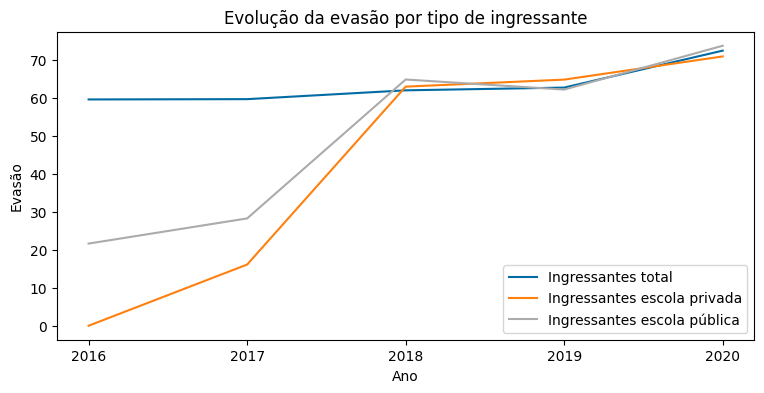

In [15]:
# Ver galeria de estilos: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('tableau-colorblind10')

# Preparação da área (tamanho da figura) e painel gráfico
plt.subplots( nrows=1, ncols=1, figsize = (9, 4))

# Plotar o gráfico para a série pandas
x = ['2016','2017','2018','2019','2020']
plt.plot(x,rpv.EVASAO,label="Ingressantes total")
plt.plot(x,rpv.EVASAOpv,label="Ingressantes escola privada")
plt.plot(x,rpv.EVASAOpb, label="Ingressantes escola pública")

# Rotular 
plt.xlabel("Ano")
plt.ylabel("Evasão")
plt.title("Evolução da evasão por tipo de ingressante")
plt.legend()

# Finalizar exibição
plt.show()

In [16]:
# Gráfico de evasão por região
plt.figure()
r5c.filter(items = ['EVASAO', 'EVASAOpv','EVASAOpb']).plot(kind='bar')

<AxesSubplot: xlabel='NO_REGIAO_IES'>

<Figure size 640x480 with 0 Axes>

<AxesSubplot: xlabel='SG_UF_IES'>

<Figure size 640x480 with 0 Axes>

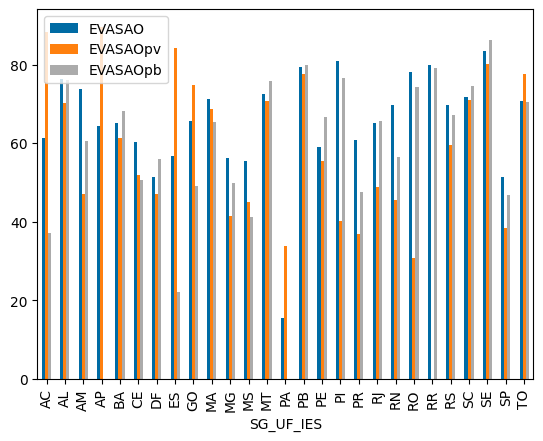

In [17]:
# Gráfico de evasão por estado
plt.figure()
r6.filter(items = ['EVASAO', 'EVASAOpv','EVASAOpb']).plot(kind='bar')